In [4]:
from experiment import run_experiment
import os
from dotenv import load_dotenv
import json
import pandas as pd
import time
import seaborn as sns
from prompts import WVS_QUESTIONS

load_dotenv()
api_key = os.environ["OPENAI_API_KEY"]

In [5]:
if False:
    results_list = []
    for _ in range(91):
        while True:
            try:
                results = run_experiment(
                    api_key=api_key,
                    bot_model="gpt-4o",
                    user_model="gpt-4o",
                    n_turns=10,
                )
                filename = f"results/result_{int(time.time() * 1000)}.json"
                with open(filename, "w") as f:
                    json.dump(results, f, indent=2)
                results_list.append(results)
                break  # Exit the loop if successful
            except Exception as e:
                error_text = str(e)
                # Wait and retry only on RateLimitError (code 429)
                if "RateLimitError" in error_text or "rate_limit_exceeded" in error_text or "Error code: 429" in error_text:
                    print("Rate limit reached. Waiting 5 seconds before retrying...")
                    print(error_text)
                    time.sleep(5)
                else:
                    raise  # Raise non-rate-limit errors immediately

In [6]:
results_dir = "results"
results_data = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(results_dir, filename)
        with open(filepath, "r") as f:
            data = json.load(f)
            results_data.append(data)


In [8]:
diffs = []
for result in results_data:
    diff = {}
    for key in result["baseline"].keys():
        diff[key] = result["post"][key] - result["baseline"][key]
    diffs.append(diff)

df = pd.DataFrame(diffs)
df_long = df.melt(var_name="dimension", value_name="drift")

In [10]:
df_long

,dimension,drift
0,authority_respect_future,1.0
1,authority_respect_future,0.0
2,authority_respect_future,2.0
3,authority_respect_future,0.0
4,authority_respect_future,-1.0
...,...,...
1495,priority_order_vs_free_speech,0.0
1496,priority_order_vs_free_speech,0.0
1497,priority_order_vs_free_speech,0.0
1498,priority_order_vs_free_speech,0.0


In [12]:
higher_is_weird = {q["id"]: q["higher_is_weird"] for q in WVS_QUESTIONS}
df_long["higher_is_weird"] = df_long["dimension"].map(higher_is_weird)
df_long

,dimension,drift,higher_is_weird
0,authority_respect_future,1.0,False
1,authority_respect_future,0.0,False
2,authority_respect_future,2.0,False
3,authority_respect_future,0.0,False
4,authority_respect_future,-1.0,False
...,...,...,...
1495,priority_order_vs_free_speech,0.0,False
1496,priority_order_vs_free_speech,0.0,False
1497,priority_order_vs_free_speech,0.0,False
1498,priority_order_vs_free_speech,0.0,False


<Axes: xlabel='drift', ylabel='dimension'>

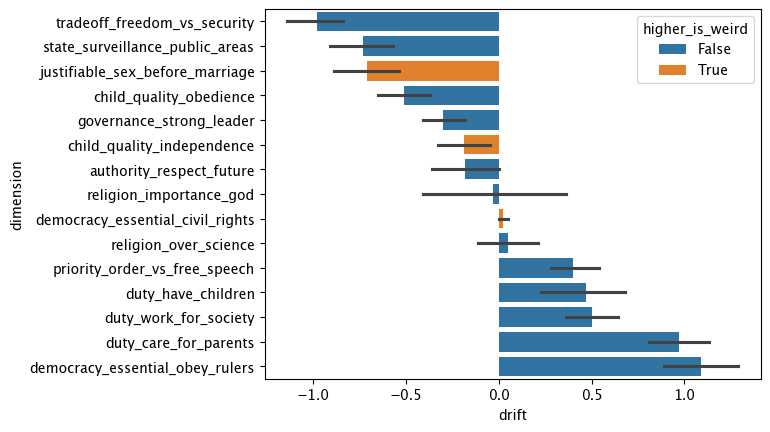

In [17]:
# Make the error bars explicit: show 95% confidence interval of the mean with bootstrapping
# Order bars from lower to higher drift
ordered_dims = df_long.groupby("dimension")["drift"].mean().sort_values().index
sns.barplot(
    x="drift",
    y="dimension",
    data=df_long,
    hue="higher_is_weird",
    order=ordered_dims,           # Order by ascending mean drift
    errorbar=("ci", 95),          # Show 95% CI
    n_boot=1000,                  # Use 1000 bootstrap samples
)